In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.special import gamma

from imripy import halo
from imripy import merger_system as ms
from imripy import inspiral
from imripy import waveform
from imripy import detector

#import plot_utils

## Dyanmical Friction with and without DM phase space

### Compare to https://arxiv.org/pdf/1908.10241.pdf

In [2]:
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 10  * ms.solar_mass_to_pc

# The luminosity distance to the system
D = 5e8  # in pc

rho_spike = 226 * ms.solar_mass_to_pc
r_spike = 0.54

一共支持这么多 profile, 写一个新的似乎并不困难 .

``` python
halo.SpikedNFW
halo.DynamicSS
halo.ConstHalo
halo.Hernquist
halo.MatterHalo
halo.NFW
halo.Spike
```

In [3]:
# static cases
sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sp_dm1_stat = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 1.5), D)
sp_dm2_stat = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 2.), D)
sp_dm3_stat = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, 7./3.), D)

In [4]:
def makeDynamicSpike(sp_stat):
    extPotential = lambda r:sp_stat.m1/r
    r_grid = np.geomspace(1e-1*sp_stat.r_isco(), 1e8*sp_stat.r_isco(), 100)
    Eps_grid = np.geomspace(extPotential(r_grid[-1]), extPotential(r_grid[0]), 500)
    dynSpike = halo.DynamicSS.FromSpike(Eps_grid, sp_stat, sp_stat.halo)
    sp_dyn = ms.SystemProp(sp_stat.m1, sp_stat.m2, dynSpike, sp_stat.D)
    return sp_dyn

In [5]:
# with phase space description
sp_dm1_dyn  = makeDynamicSpike(sp_dm1_stat)
sp_dm2_dyn  = makeDynamicSpike(sp_dm2_stat)
sp_dm3_dyn  = makeDynamicSpike(sp_dm3_stat)

In [6]:
def compareModels(sp_stat, sp_dyn, a0, e0, lnLambda1, lnLambda2, ax_ea, label="", acc=1e-10, verbose=1, color=None):
    afin = sp_stat.r_isco()
  
    inspiral.Classic.ln_Lambda = lnLambda1
    ev_stat = inspiral.Classic.Evolve(sp_stat, a0, e_0=e0, a_fin=afin, opt=inspiral.Classic.EvolutionOptions(accretion=False, verbose=verbose, accuracy=acc))
    l, = ax_ea.plot( ev_stat.a*(1.-ev_stat.e**2)/sp_stat.m1, ev_stat.e, label=label+r", stat", linestyle='-.', alpha=0.6, color=color)
    inspiral.Classic.ln_Lambda = lnLambda2
    ev_dyn = inspiral.Classic.Evolve(sp_dyn, a0, e_0=e0, a_fin=afin, opt=inspiral.Classic.EvolutionOptions(accretion=False, verbose=verbose, accuracy=acc, haloPhaseSpaceDescription=True))
    ax_ea.plot(ev_dyn.a*(1.-ev_dyn.e**2)/sp_stat.m1, ev_dyn.e, color=l.get_c(), label=label+r", psd")

Evolving from  915.7509157509156  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 2.0671s
Evolving from  915.7509157509156  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: accretion = False, haloPhaseSpaceDescription = True, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 27.5491s
Evolving from  915.7509157509156  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: accretion = False, haloPhaseSpaceDescription = False, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 2.0520s
Evolving from  915.7509157509156  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: accretion = False, haloPhaseSpaceDescription = True, accuracy = 1.0e-10
A termination event occurred.
 -> Evolution took 22.6556s
Evolving from  915.7509157509156  to  1.0 r_isco  with initial eccentricity 0.3  with  Options: 

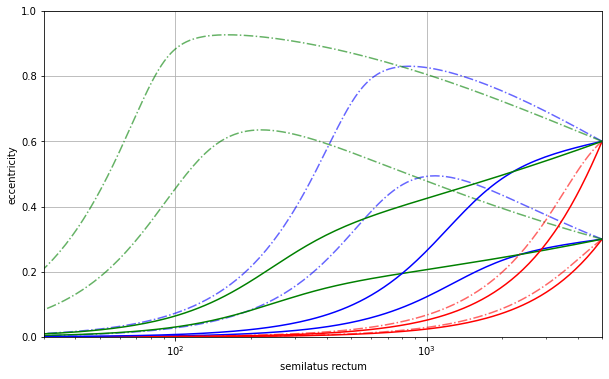

In [8]:
fig = plt.figure(figsize=(10,6)); ax_ea = fig.gca()
p0 = 5000 * m1
e0 = 0.3
a0 = p0 /(1-e0**2) 
compareModels(sp_dm1_stat, sp_dm1_dyn, a0, e0, 10., -1, ax_ea, color='red', label=r"$\alpha_\text{spike}=1.5$")
compareModels(sp_dm2_stat, sp_dm2_dyn, a0, e0, 10., -1, ax_ea, color='blue', label=r"$\alpha_\text{spike}=2$")
compareModels(sp_dm3_stat, sp_dm3_dyn, a0, e0, 10., -1, ax_ea, color='green', label=r"$\alpha_\text{spike}=7/3$")

e0 = 0.6
a0 = p0 /(1-e0**2) 
compareModels(sp_dm1_stat, sp_dm1_dyn, a0, e0, 10., -1, ax_ea, color='red', label=r"$\alpha_\text{spike}=1.5$")
compareModels(sp_dm2_stat, sp_dm2_dyn, a0, e0, 10., -1, ax_ea, color='blue', label=r"$\alpha_\text{spike}=2$")
compareModels(sp_dm3_stat, sp_dm3_dyn, a0, e0, 10., -1, ax_ea, color='green', label=r"$\alpha_\text{spike}=7/3$")
                 
                 
ax_ea.set_xscale('log')
ax_ea.set_xlim(left=3e1, right=p0/m1); 
ax_ea.set_ylim(bottom=0., top=1.)
ax_ea.set_xlabel("semilatus rectum")
ax_ea.set_ylabel("eccentricity")
ax_ea.grid()
fig.savefig("plots/xiEffects_pe.pdf")

### Compare dephasing effects

In [ ]:
def compareN2(sp_0, sp_stat, sp_dyn, a0, e0, lnLambda, ax_dN2, label="", acc=1e-10, verbose=1, color=None):
    afin = sp_stat.r_isco()

    inspiral.Classic.ln_Lambda = lnLambda
    ev_0 = inspiral.Classic.Evolve(sp_0, a0, e_0=e0, a_fin=afin,
                                      opt=inspiral.Classic.EvolutionOptions(accretion=False, verbose=verbose, accuracy=acc))
    f_gw_0, N2_0 = waveform.N_cycles_n(2, sp_0, ev_0)
    N2_0_interp = interp1d(f_gw_0, N2_0, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    
    ev_stat = inspiral.Classic.Evolve(sp_stat, a0, e_0=e0, a_fin=afin,
                                      opt=inspiral.Classic.EvolutionOptions(accretion=False, verbose=verbose, accuracy=acc))
    f_gw_stat, N2_stat = waveform.N_cycles_n(2, sp_stat, ev_stat)
    N2_stat_interp = interp1d(f_gw_stat, N2_stat, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    
    ev_dyn = inspiral.Classic.Evolve(sp_dyn, a0, e_0=e0, a_fin=afin,
                                     opt=inspiral.Classic.EvolutionOptions(haloPhaseSpaceDescription=True, accretion=False, verbose=verbose, accuracy=acc))
    f_gw_dyn, N2_dyn = waveform.N_cycles_n(2, sp_dyn, ev_dyn)

    dN2_stat =  np.abs(N2_stat - N2_0_interp(f_gw_stat))
    dN2_stat_interp = interp1d(f_gw_stat, dN2_stat, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    dN2_dyn = np.abs(N2_dyn - N2_0_interp(f_gw_dyn))
    
    #l, = ax_dN2.loglog(f_gw_stat/ms.hz_to_invpc, dN2_stat, label=r"$|\Delta N^{(2)}_{stat}|$" + label)
    #ax_dN2.loglog(f_gw_dyn/ms.hz_to_invpc, dN2_dyn, 
    #                      color = l.get_c(), linestyle='--', label=r"$|\Delta N^{(2)}_{dyn}|$" + label)

    ax_dN2.plot(f_gw_dyn/ms.hz_to_invpc, dN2_dyn/dN2_stat_interp(f_gw_dyn), 
                           label= label)

In [ ]:
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1  * ms.solar_mass_to_pc

D = 5e8  # in pc
rho_spike = 226 * ms.solar_mass_to_pc
r_spike = 0.54
alpha = 7/3

sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sp_dm_stat = ms.SystemProp(m1, m2, halo.Spike(rho_spike, r_spike, alpha), D)
sp_dm_dyn  = makeDynamicSpike(sp_dm_stat)

In [ ]:
fig = plt.figure(figsize=(10,6)); ax_dN2 = fig.gca()
a0 = 200 * sp_0.r_isco()

e0 = 1e-4
compareN2(sp_0, sp_dm_stat, sp_dm_dyn, a0, e0, -1, ax_dN2, label=r"$e_0=10^{-4}$")
e0 = 0.2
compareN2(sp_0, sp_dm_stat, sp_dm_dyn, a0, e0, -1, ax_dN2, label=r"$e_0=0.2$")
e0 = 0.9
compareN2(sp_0, sp_dm_stat, sp_dm_dyn, a0, e0, -1, ax_dN2, label=r"$e_0=0.9$")

plt.grid(); 
plt.xscale('log'); plt.ylim(bottom = 0., top=1.1)
plt.xlim(right=1)
plt.xlabel("frequency / Hz")
plt.ylabel("$\Delta N^{(2)}_{psd}/\Delta N^{(2)}_{stat}$")
plt.axhline(0.58, color='black')
plt.legend(loc='upper right')
fig.savefig("plots/xi_dephasing.pdf")

## GWsignal effects

In [ ]:
# The masses of the primary and secondary object
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1. * ms.solar_mass_to_pc

# The luminosity distance to the system
D = 1e8  # in pc

# The system without any dark matter
sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

# The dark matter spike according to https://arxiv.org/pdf/2108.04154.pdf
rho6 = 5.448e15 * ms.solar_mass_to_pc  # in 1/pc^2 
alphas = [(7./3., r'$\alpha_{spike}=7/3$'), (9./4., r'$\alpha_{spike}=9/4$'), (7./4., r'$\alpha_{spike}=7/4$')]
sps_dm_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]

In [ ]:
# Plots for comparison
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2"])
plt.figure(figsize=(10, 8))
ax_pc = plt.gca()
ax_risco = ax_pc.twiny()
r_grid = np.geomspace(sp_0.r_isco(), 1e6*sp_0.r_isco())
for sp, label in sps_dm_dyn:
    l, = ax_pc.loglog(r_grid, sp.halo.density(r_grid)/ms.solar_mass_to_pc, label=label)
    ax_risco.loglog(r_grid/sp_0.r_isco(), sp.halo.density(r_grid)/ms.solar_mass_to_pc, color=l.get_c())

ax_pc.set_xlabel("r / pc"); ax_risco.set_xlabel("r / $r_{isco}$"); ax_pc.set_ylabel(r"Density / $M_\odot/pc^3$")
ax_pc.legend(); ax_pc.grid()
plt.savefig("plots/rho_dm.pdf")

In [ ]:
# Set the coulomb logarithm to ln sqrt(m1/m2)
inspiral.Classic.ln_Lambda = -1

# and final condition
afin = 1. * sp_0.r_isco()

In [ ]:
def plotEvolution(sp, ev, ax_a=None, ax_e=None, label="", ax_ae=None, ax_m=None, m2=1.):
    l = None
    if not ax_a is None:
        l, = ax_a.loglog(ev.t/ms.year_to_pc, ev.a/sp.r_isco(), label=label)
    if not ax_e is None:
        l, = ax_e.loglog(ev.t/ms.year_to_pc, ev.e, color=(l.get_c() if not l is None else None), label=label)
    if not ax_m is None:
        l, = ax_m.loglog(ev.t/ms.year_to_pc, ev.m2/m2-1., linestyle='--', color=(l.get_c() if not l is None else None), label=label)
    if not ax_ae is None:
        l, = ax_ae.plot(ev.a/sp.r_isco(), ev.e, color=(l.get_c() if not l is None else None), label=label)
    return l

from itertools import cycle
def plotGWcharacteristicStrain(sp, ev, ax_h, label="", acc=1e-13, harmonics=[2]): 
    linecycler = cycle(["-", "--", "-.", ":"])
    color_cycle = ax_h._get_lines.prop_cycler
    l = None
    for n in harmonics:
        wf = waveform.h_n(n, sp, ev, acc=acc)
        l, = ax_h.loglog(wf[0]/ms.hz_to_invpc, 2.*wf[0]*np.abs(wf[1]), linestyle=next(linecycler), color=(l.get_c() if not l is None else next(color_cycle)['color']),
                                 label=r"$h^{(" + str(n) +")}_{c,+," + label +"}$" if (n == 2 and not label is None) else None)


def compareModels(sp_0, sp_dms, a0, e0, ax_a=None, ax_e=None, ax_ae=None, ax_h=None, ax_dN2=None, ax_m=None,
                               label="", acc=1e-10, verbose=1, afin=None, fgw5year_line=False):  
    # calculate evolution and plot it
    if afin is None:
        afin = sp_0.r_isco()
    # no dm
    ev_0 =  inspiral.Classic.Evolve(sp_0, a0, e0, a_fin=afin,
                                opt=inspiral.Classic.EvolutionOptions(accretion=False, verbose=verbose, accuracy=acc))
    plotEvolution(sp_0, ev_0, ax_a, ax_e, ax_ae=ax_ae, label=label + r'\text{vacuum}')
    if not ax_h is None:
        plotGWcharacteristicStrain(sp_0, ev_0, ax_h, label=label+ r'\text{vacuum}' , harmonics=[2])
    fgw_0, N2_0 = waveform.N_cycles_n(2, sp_0, ev_0)
    N2_0interp = interp1d(fgw_0, N2_0, kind='cubic', bounds_error=False, fill_value=(0.,0.))
    if fgw5year_line:
        f_gw5yr = interp1d(ev_0.t, fgw_0, kind='cubic', bounds_error=True)(ev_0.t[-1] - 5.*ms.year_to_pc)
        ax_dN2.axvline(f_gw5yr/ms.hz_to_invpc, linestyle='--')
    
    t_fin = ev_0.t[-1] *  10**(-2.*(np.log10(a0/afin) - 2.)) 
    
    for sp_dm,label_dm in sp_dms:
        ev_dm = inspiral.Classic.Evolve(sp_dm, a0, e0, a_fin=afin, t_fin=t_fin,
                                        opt=inspiral.Classic.EvolutionOptions(accretion=False, haloPhaseSpaceDescription=True, verbose=verbose, accuracy=acc))
        l_dm = plotEvolution(sp_dm, ev_dm, ax_a, ax_e, ax_ae=ax_ae, label=label + label_dm)

        # Plot the characteristic strain of the second harmonic
        if not ax_h is None:
            plotGWcharacteristicStrain(sp_dm, ev_dm, ax_h, label=None, harmonics=[2,3])

        # Calculate Delta N for the second harmonic
        if not ax_dN2 is None:
            fgw_dm, N2_dm = waveform.N_cycles_n(2, sp_dm, ev_dm)
            ax_dN2.loglog(fgw_dm/ms.hz_to_invpc, np.abs(N2_0interp(fgw_dm) - N2_dm), label=r"$\Delta N^{(2)}$,"+label_dm, color=(l_dm.get_c() if not l_dm is None else None))

    

In [ ]:
def preparePlots( figF, axesF, axes_ae=None, ax_m=None, axes_a=None, e_min=1e-5, f_min=8e-4):
    figF.subplots_adjust(hspace=0, wspace=0)
    
    if not axes_ae is None:
        for ax in axes_ae:
            ax.set_xlabel('semimajor axis / $r_{isco}$')
            ax.grid()
        axes_ae[0].set_ylabel('eccentricity')
        if axes_a is None:
            axes_ae[-1].legend(loc='upper left', bbox_to_anchor=(0.9, 1.))
        #axes_ae[0].set_ylim(bottom=e_min, top =1.)
    #if np.shape(axesT)[0] > 2:
    #    axesT[2,0].set_ylabel(r'$\Delta m_2/m_2$')
    #    axesT[2,0].set_ylim(bottom=1e-4)
    
    if not axes_a is None:
        for ax in axes_a:
            ax.set_xlabel('time / yr')
            ax.grid()
        axes_a[0].set_ylabel('semimajor axis / $r_{isco}$')
        axes_a[-1].legend(loc='upper left', bbox_to_anchor=(0.9, 1.))
    
    axesF[0,0].set_ylabel('characteristic strain')
    axesF[1,0].set_ylabel(r'$|\Delta N^{(2)}|$')
    f_gw = np.geomspace(detector.Lisa().Bandwith()[0], detector.Lisa().Bandwith()[1], 100)
    for ax in axesF[0,:]:
        ax.loglog(f_gw/ms.hz_to_invpc, detector.Lisa().NoiseStrain(f_gw), label='LISA')
    for ax in axesF[1,:]:
        ax.set_xlabel('frequency / Hz')
    axesF[0,0].set_ylim(bottom=1e-23)
    from matplotlib.lines import Line2D
    explanatory_lines = [mpl.lines.Line2D([0], [0], color='black', linestyle='-'), 
                          mpl.lines.Line2D([0], [0], color='black', linestyle='--'),
                          mpl.lines.Line2D([0], [0], color="#832db6")]

    axesF[0,-1].legend(explanatory_lines, ["$h^{(2)}_{c,+}$", "$h^{(3)}_{c,+}$", "LISA"],
                           loc='upper left', bbox_to_anchor=(0.9, 1.))
    if axes_a is None and axes_ae is None:
        axesF[1,-1].legend(loc='upper left', bbox_to_anchor=(0.9, 1.))
    axesF[-1,0].set_ylim(bottom=1., top=1e8)
    axesF[-1,0].set_xlim(left=f_min)

    for ax in axesF.flatten():
        ax.grid()

In [ ]:
# An example case
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#94a4a2", "#3f90da", "#ffa90e", "#bd1f01", "#832db6"])
figT, axes_ae = plt.subplots(2, 1, figsize=(6,10))
figF, axes_gw = plt.subplots(2, 1, sharex='col', figsize=(6,10))

# Set initial conditions for orbital evolution
a0 = 100 * sp_0.r_isco()
e0 = 0.1

compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axes_ae[0], 
                           ax_ae=axes_ae[1], ax_h=axes_gw[0], ax_dN2=axes_gw[1], fgw5year_line=True)

preparePlots(figF, np.array([[axes_gw[0]], [axes_gw[1]]]), axes_ae=[axes_ae[1]], axes_a=[axes_ae[0]])
figT.savefig("plots/evolution_example.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_example.pdf", bbox_inches="tight")

In [ ]:
# Look at different initial eccentricities
figT, axesT = plt.subplots(2, 3, figsize=(16, 10), sharex='col')
figF, axesF = plt.subplots(2, 3, figsize=(16,10), sharex='all', sharey='row')
# Set initial conditions for orbital evolution
a0 = 100 * sp_0.r_isco()
e0 = 1e-4
axesT[0,0].set_title(r"$e_0=10^{-4}$");# axesF[0,0].set_title(r"$e_0=10^{-4}$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_h=axesF[0,0], ax_dN2=axesF[1,0])
e0 = 1e-1
axesT[0,1].set_title(r"$e_0=0.1$");# axesF[0,1].set_title(r"$e_0=0.1$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_h=axesF[0,1], ax_dN2=axesF[1,1])
e0 = 0.6
axesT[0,2].set_title(r"$e_0=0.6$"); #axesF[0,2].set_title(r"$e_0=0.6$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_h=axesF[0,2], ax_dN2=axesF[1,2])

preparePlots( figF, axesF, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
axesT[0,0].set_yscale('log')
figT.savefig("plots/evolution_e0.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_e0.pdf", bbox_inches="tight")

In [ ]:
# Look at different initial separation
figT, axesT = plt.subplots(2, 3, figsize=(16,10), sharey='row')
figF, axesF = plt.subplots(2, 3, figsize=(16,10), sharex='all', sharey='row')

e0 = 1e-1
a0 = 1e2*sp_0.r_isco()
axesT[0,0].set_title(r"$a_0=10^2r_{isco}$");# axesF[0,0].set_title(r"$a_0=10^2r_{isco}$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_h=axesF[0,0], ax_dN2=axesF[1,0])
a0 = 1e3*sp_0.r_isco()
axesT[0,1].set_title(r"$a_0=10^3r_{isco}$");# axesF[0,1].set_title(r"$a_0=10^3r_{isco}$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_h=axesF[0,1], ax_dN2=axesF[1,1], acc=1e-11)
a0 = 1e4*sp_0.r_isco()
axesT[0,2].set_title(r"$a_0=10^4r_{isco}$"); #axesF[0,2].set_title(r"$a_0=10^4r_{isco}$")
compareModels(sp_0, sps_dm_dyn, a0, e0, ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_h=axesF[0,2], ax_dN2=axesF[1,2])

preparePlots( figF, axesF, f_min=1e-4, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
figT.savefig("plots/evolution_a0.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_a0.pdf", bbox_inches="tight")

In [ ]:
# Look at different Dark Matter Densities
figT, axesT = plt.subplots(2, 3, figsize=(16,10), sharey='row')
figF, axesF = plt.subplots(2, 3, figsize=(16,10), sharex='all', sharey='row')

a0 = 100. * sp_0.r_isco()
e0 = 0.1


rho6 = 5.448e13 * ms.solar_mass_to_pc  # in 1/pc^2 
sps_dm1_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
axesT[0,0].set_title(r"$\rho_6=" + plot_utils.latex_float(rho6/ms.solar_mass_to_pc) + "M_\odot/pc^3$")
compareModels(sp_0, sps_dm1_dyn, a0, e0, ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_h=axesF[0,0], ax_dN2=axesF[1,0])

rho6 = 5.448e15 * ms.solar_mass_to_pc  # in 1/pc^2 
sps_dm2_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
axesT[0,1].set_title(r"$\rho_6=" + plot_utils.latex_float(rho6/ms.solar_mass_to_pc) + "M_\odot/pc^3$")
compareModels(sp_0, sps_dm2_dyn, a0, e0, ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_h=axesF[0,1], ax_dN2=axesF[1,1])

rho6 = 5.448e17 * ms.solar_mass_to_pc  # in 1/pc^2 
sps_dm3_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
axesT[0,2].set_title(r"$\rho_6=" + plot_utils.latex_float(rho6/ms.solar_mass_to_pc) + "M_\odot/pc^3$")
compareModels(sp_0, sps_dm3_dyn, a0, e0, ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_h=axesF[0,2], ax_dN2=axesF[1,2])

preparePlots( figF, axesF, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
figT.savefig("plots/evolution_rho6.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_rho6.pdf", bbox_inches="tight")

In [ ]:
# Look at different m1
figT, axesT = plt.subplots(2, 3, figsize=(16,10), sharey='row')
figF, axesF = plt.subplots(2, 3, figsize=(16,10), sharex='all', sharey='row')

rho6 = 5.448e15 * ms.solar_mass_to_pc  # in 1/pc^2
e0 = 0.1
# 1
m1 = 1e3 * ms.solar_mass_to_pc
sp_0_1 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sps_dm_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
a0 = 1e2*sp_0_1.r_isco()
axesT[0,0].set_title(r"$m_1 = 10^3 M_{\odot}$"); #axesF[0,0].set_title(r"$m_1 = 10^3 M_{\odot}$")
compareModels(sp_0_1, sps_dm_dyn, a0, e0, ax_a=axesT[0,0], ax_ae=axesT[1,0], ax_h=axesF[0,0], ax_dN2=axesF[1,0], fgw5year_line=True)

# 2
m1 = 1e4 * ms.solar_mass_to_pc
sp_0_2 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sps_dm2_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
a0 = 1e2*sp_0_2.r_isco()
axesT[0,1].set_title(r"$m_1 = 10^4 M_{\odot}$"); #axesF[0,1].set_title(r"$m_1 = 10^4 M_{\odot}$")
compareModels(sp_0_2, sps_dm2_dyn, a0, e0, ax_a=axesT[0,1], ax_ae=axesT[1,1], ax_h=axesF[0,1], ax_dN2=axesF[1,1], acc=1e-11, fgw5year_line=True)
# 3
m1 = 1e5 * ms.solar_mass_to_pc
sp_0_3 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)
sps_dm3_dyn = [(makeDynamicSpike(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D)), label) for alpha,label in alphas]
a0 = 1e2*sp_0_3.r_isco()
axesT[0,2].set_title(r"$m_1 = 10^5 M_{\odot}$"); #axesF[0,2].set_title(r"$m_1 = 10^5 M_{\odot}$")
compareModels(sp_0_3, sps_dm3_dyn, a0, e0, ax_a=axesT[0,2], ax_ae=axesT[1,2], ax_h=axesF[0,2], ax_dN2=axesF[1,2], acc=1e-11, fgw5year_line=True)

preparePlots(figF, axesF, f_min=1e-4, axes_ae = axesT[1,:], axes_a=axesT[0,:])
figT.subplots_adjust(wspace=0)
figT.savefig("plots/evolution_m1.pdf", bbox_inches="tight"); figF.savefig("plots/gwSignal_m1.pdf", bbox_inches="tight")

### Circularization Rate

In [ ]:
# The masses of the primary and secondary object
m1 = 1e3 * ms.solar_mass_to_pc
m2 = 1. * ms.solar_mass_to_pc

# The luminosity distance to the system
D = 1e8  # in pc

# The system without any dark matter
sp_0 = ms.SystemProp(m1, m2, halo.ConstHalo(0.), D)

# The dark matter spike according to https://arxiv.org/pdf/2108.04154.pdf
rho6 = 5.448e15 * ms.solar_mass_to_pc  # in 1/pc^2 
alphas = [(7./3., r'$\alpha_{spike}=7/3$'), (2., r'$\alpha_{spike}=2$')]#, (1.5, r'$\alpha_{spike}=3/2$')]
sps_dm_stat = [(ms.SystemProp(m1, m2, halo.Spike.FromRho6(rho6, m1, alpha), D), label) for alpha,label in alphas]
sps_dm_dyn = [ (makeDynamicSpike(sp_stat), label) for sp_stat,label in  sps_dm_stat]

In [ ]:
def compareCircularizationRate(sps_dyn, sps_stat, a0, e0, axes_ae=None, axes_dade=None, justDF=True, plotApprox=True, verbose=1, acc=1e-10, label=""):
    for (sp, labelsp), (sp_stat, _) in zip(sps_dyn, sps_stat):
        afin = sp.r_isco()
        ev = inspiral.Classic.Evolve(sp, a0, e0, a_fin=afin,
                                opt=inspiral.Classic.EvolutionOptions(gwEmissionLoss= not justDF, haloPhaseSpaceDescription=True,
                                                                      accretion=False, verbose=verbose, accuracy=acc))
        if not axes_ae is None:
            l, = axes_ae.plot(ev.a/sp.r_isco(), ev.e, label=label + labelsp)
        if not axes_dade is None:
            l, = axes_dade.plot(ev.a/sp.r_isco(), np.abs(np.gradient(ev.e, ev.a)), linestyle='--' if axes_ae==axes_dade else '-', color=(l.get_c() if not axes_ae is None else None), label=(label + labelsp if axes_ae is None else None)
                                                                            , alpha=0.5)
            if plotApprox:
                alpha = -sp_stat.halo.alpha
                beta = 2.27 - 2.
                #beta = 1
                dade_ana = (ev.e/2. * (1.-ev.e**2) / ev.a  
                                    #* -alpha / (1. + ev.e**2/4.*(2. + alpha**2 + alpha)))
                                    * (-1. + beta - alpha) / (1. + ev.e**2/4.*(3. + alpha**2 + alpha*(3.-2.*beta) - 2.*beta + beta**2 )))
                axes_dade.plot(ev.a/sp.r_isco(), np.abs(dade_ana), linestyle='-.', color=l.get_c())

In [ ]:
fig, (axes_ae, axes_dade) = plt.subplots(2, 1, figsize=(6, 12), sharex='col')

a0 = 1e3 * sp_0.r_isco()
e0 = 0.1

compareCircularizationRate(sps_dm_dyn, sps_dm_stat, a0, e0, axes_ae=axes_ae, axes_dade=axes_dade, justDF=True)

axes_ae.grid(); axes_dade.grid()
axes_ae.legend()

axes_dade.set_yscale('log')
fig.subplots_adjust(hspace=0)